In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [35]:
# Conventional demodulation
def demapper_sym(symbols_I, symbols_Q, Ns, threshold = 2.0):
   symbol = []
   for i in range(Ns):
        if symbols_I[i] <= -threshold and symbols_Q[i] >= threshold: #-3+3j
            symbol.append(0)
        elif symbols_I[i] <= -threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #-3+1j
            symbol.append(1)
        elif symbols_I[i] <= -threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #-3-j
            symbol.append(3)
        elif symbols_I[i] <= -threshold and symbols_Q[i] <= -threshold: #-3-3j
            symbol.append(2)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] >= threshold: #-1+3j
            symbol.append(4)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #-1+j
            symbol.append(5)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #-1-j
            symbol.append(7)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] <= -threshold: #-1-3j
            symbol.append(6)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] >= threshold: #1+3j
            symbol.append(12)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #1+j
            symbol.append(13)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #1-j
            symbol.append(15)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] <= -threshold: #1-3j
            symbol.append(14)
        elif symbols_I[i] >= threshold and symbols_Q[i] >= threshold: #3+3j
            symbol.append(8)
        elif symbols_I[i] >= threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #3+1j
            symbol.append(9)
        elif symbols_I[i] >= threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #3-1j
            symbol.append(11)
        elif symbols_I[i] >= threshold and symbols_Q[i] <= -threshold: #3-3j
            symbol.append(10)
   return np.array(symbol)

# Function tha calculate the bit error rate (BER) of two vectors with 4 bits
def bit_error_rate(y_pred, y_test):
    pred = ''.join([f"{sym:04b}" for sym in y_pred])
    test = ''.join([f"{sym:04b}" for sym in y_test])

    pred = np.array(list(pred))
    test = np.array(list(test))

    # Calculate the BER with the two strings
    ber = 0
    for i, j in zip(pred, test):
        if i != j:
            ber += 1
    
    return ber/len(pred)

# Function that calculate the symbol error rate (SER) of two vectors
def symbol_error_rate(y_pred, y_test):
    # Calculate the SER
    return np.sum(y_pred!=y_test)/len(y_pred)

# Add noise to the signal
def add_noise(signal, target_snr_db):
    X_avg_p = np.mean(signal**2)
    X_avg_db = 10 * np.log10(X_avg_p)
    noise_avg_db_r = X_avg_db - target_snr_db
    noise_avg_p_r = 10 ** (noise_avg_db_r / 10)
    mean_noise = 0
    noise_r = np.random.normal(mean_noise, np.sqrt(noise_avg_p_r), len(signal))
    return signal + noise_r

# Function that sincronize the signals
def sync_signals(tx, rx):
    trans = np.concatenate((tx, tx))
    corr = np.abs(np.correlate(np.abs(trans) - np.mean(np.abs(trans)),
                        np.abs(rx) - np.mean(np.abs(rx)), mode='full'))
    delay = np.argmax(corr) - len(rx) + 1
    signal = trans[delay:]
    signal = signal[:len(rx)]
    return signal

# Function that demodulate the signal 16-QAM
def demodulate(signal):
    mod_dict = {-3+3j:0, -3+1j:1, -3-3j:2, -3-1j:3,
            -1+3j:4, -1+1j:5, -1-3j:6, -1-1j:7,
            3+3j:8, 3+1j:9, 3-3j:10, 3-1j:11,
            1+3j:12, 1+1j:13, 1-3j:14, 1-1j:15}
    symbols = []
    for i in range(len(signal)):
        symbols.append(mod_dict[signal[i]])
    return np.array(symbols)

In [36]:
# import .mat file
df_tx = pd.DataFrame()
file = sio.loadmat('DB\\2x16QAM_16GBd.mat')
df_tx['Tx'] = file['Constellation'][0][0][0][0]
df_tx.head()

,Tx
0,3.0+3.0j
1,-3.0-3.0j
2,3.0-1.0j
3,-3.0+3.0j
4,-3.0+3.0j


In [37]:
OSNR = [20, 21.5, 23, 25, 27, 30, 32, 35, 40]
df_rx = pd.DataFrame()
for val in OSNR:
    rot = 3*np.pi/2
    if val == 23 or val == 25:
        rot = np.pi
    elif val == 20:
        rot = 0
    file = sio.loadmat('DB\\15.5GHz\\16QAM_3x16GBd_consY'+str(val)+'dB.mat')
    
    # Normalize the signal between -3 and 3
    file = file['const_Y'][0]
    file = (file - np.mean(file))/np.std(file)
    file = file * 3
    df_rx[str(val)+'dB'] = file*np.exp(1j*rot)
df_rx.head()

,20dB,21.5dB,23dB,25dB,27dB,30dB,32dB,35dB,40dB
0,1.639193-2.864446j,2.223405-2.569107j,-3.826914+3.647714j,3.210192-0.880348j,1.608691-2.933338j,3.129326+0.445444j,0.992973-2.654904j,-3.393323+2.205308j,0.593951-1.136062j
1,2.031449+0.380656j,-2.955521+2.290002j,3.255746-3.370660j,0.563303+2.368071j,3.160963-1.510941j,0.804176-0.965949j,-1.022128+0.928340j,-1.231110+1.234531j,-2.779448-0.642660j
2,-0.096213+3.110882j,1.566678-2.457914j,-1.601408-0.944418j,0.804705-2.827221j,1.232642+0.679080j,0.913259+0.420738j,3.339929-1.198978j,2.468579+0.477067j,-3.102549+2.455300j
3,-0.882746-2.339520j,-1.961902-1.687558j,2.978924-3.060205j,1.029512+0.810397j,1.201064-0.923072j,0.187945+3.270330j,1.298172+0.991576j,-0.654355+1.274875j,0.711019+1.293929j
4,1.803395+1.087012j,-1.869490-2.404541j,-1.448447+1.076949j,2.824181+3.275104j,3.372391-0.931085j,-2.312861-3.089214j,-1.046419+0.753412j,2.267598+2.414563j,-1.376631+2.792201j


In [38]:
sync_sym = [sync_signals(df_tx['Tx'], df_rx[str(val)+'dB']) for val in OSNR]

In [39]:
y = [demodulate(sync_sym[i]) for i in range(len(OSNR))]

In [40]:
Xr = [np.real(df_rx[str(val)+'dB']) for val in OSNR]
Xi = [np.imag(df_rx[str(val)+'dB']) for val in OSNR]

In [41]:
sym_dem = [demapper_sym(Xr[i], Xi[i], len(Xr[i])) for i in range(len(OSNR))]

In [42]:
ber = [bit_error_rate(sym_dem[i], y[i]) for i in range(len(OSNR))]

In [43]:
model = KNeighborsClassifier(n_neighbors=15)
ber_knn = []
for i in range(len(OSNR)):
    X = np.transpose(np.array([Xr[i], Xi[i]]))
    X_test, X_train, y_test, y_train = train_test_split(X, y[i], test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    ber_knn.append(bit_error_rate(y_pred, y_test))

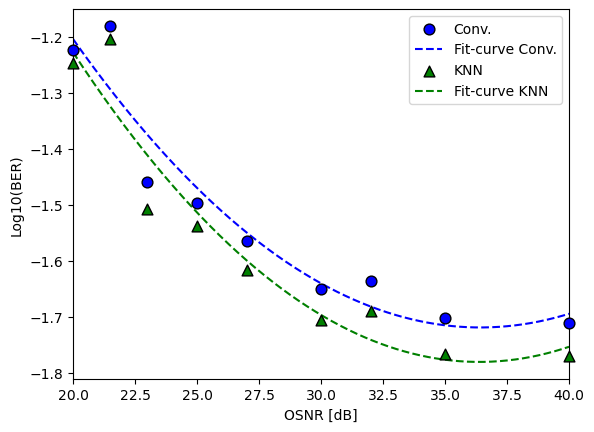

In [44]:
# Fit-curve of the BER
p1 = np.polyfit(OSNR, np.log10(ber), 2)
z1 = np.poly1d(p1)

p2 = np.polyfit(OSNR, np.log10(ber_knn), 2)
z2 = np.poly1d(p2)

x_step = np.linspace(np.min(OSNR), np.max(OSNR), 1000) # step between 4 and 16 dB

# Plot ther BER vs OSNR
plt.scatter(OSNR, np.log10(ber), color='blue', edgecolors='black',
            marker='o', s=60, zorder=3, clip_on=False, label='Conv.')
plt.plot(x_step, z1(x_step), '--b', label='Fit-curve Conv.')

plt.scatter(OSNR, np.log10(ber_knn), color='green', edgecolors='black',
            marker='^', s=60, zorder=3, clip_on=False, label='KNN')
plt.plot(x_step, z2(x_step), '--g', label='Fit-curve KNN')

plt.xlabel('OSNR [dB]')
plt.ylabel('Log10(BER)')
plt.xlim([np.min(OSNR), np.max(OSNR)])
plt.legend()
plt.show()